In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
!pip install rarfile

In [ ]:
import os
import pandas as pd
import gdown
import rarfile
import shutil
from PIL import Image
# Download the RAR file
url = 'https://drive.google.com/uc?id=1VVJ_lo2Z85MhIQ395W13opPoHQRQUKMJ'
#https://drive.google.com/file/d/1o2UTmJ_wqL3CwO1WV0prOd3p2FA7LsZH/view?usp=drive_link
output_rar = '/content/Chest_XRay_Dataset.rar'
gdown.download(url, output_rar, quiet=False)
# Extract the RAR file
with rarfile.RarFile(output_rar, 'r') as rar_ref:
    rar_ref.extractall('/content')

Downloading...
From (original): https://drive.google.com/uc?id=1VVJ_lo2Z85MhIQ395W13opPoHQRQUKMJ
From (redirected): https://drive.google.com/uc?id=1VVJ_lo2Z85MhIQ395W13opPoHQRQUKMJ&confirm=t&uuid=58f2afa9-7774-412f-b3e0-bcbc440b9f6c
To: /content/Chest_XRay_Dataset.rar
100%|██████████| 38.0M/38.0M [00:00<00:00, 92.6MB/s]


In [ ]:
# Path to the extracted dataset folder

dataset = '/content/Chest_XRay_Dataset'

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, AveragePooling2D, Flatten, Dense

def conv_block(inputs, filters, kernel_size, strides=(1, 1)):
    x = Conv2D(filters=filters[0], kernel_size=(1, 1), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[2], kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters=filters[2], kernel_size=(1, 1), strides=strides, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def identity_block(inputs, filters):
    x = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[2], kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, inputs])
    x = Activation('relu')(x)
    return x

def resnet_50():
    inputs = Input(shape=(224, 224, 3))

    # Initial layers
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = conv_block(x, [64, 64, 256], (3, 3))
    for _ in range(2):
        x = identity_block(x, [64, 64, 256])

    x = conv_block(x, [128, 128, 512], (3, 3), strides=(2, 2))
    for _ in range(3):
        x = identity_block(x, [128, 128, 512])

    x = conv_block(x, [256, 256, 1024], (3, 3), strides=(2, 2))
    for _ in range(5):
        x = identity_block(x, [256, 256, 1024])

    x = conv_block(x, [512, 512, 2048], (3, 3), strides=(2, 2))
    for _ in range(2):
        x = identity_block(x, [512, 512, 2048])

    # Final layers
    x = AveragePooling2D((7, 7))(x)
    x = Flatten()(x)
    classes=2
    outputs = Dense(classes, activation='softmax')(x)

    resnet50 = Model(inputs=inputs, outputs=outputs)
    resnet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return resnet50

model = resnet_50()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 256)    │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_4… │
├──────────────────────

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

Found 4099 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 131s 515ms/step - accuracy: 0.8548 - loss: 0.3597 - val_accuracy: 0.7299 - val_loss: 3.4652
Epoch 2/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 83s 282ms/step - accuracy: 0.9169 - loss: 0.2084 - val_accuracy: 0.7299 - val_loss: 6.1344
Epoch 3/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 37s 287ms/step - accuracy: 0.9299 - loss: 0.1857 - val_accuracy: 0.7299 - val_loss: 3.8696
Epoch 4/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 43s 303ms/step - accuracy: 0.9360 - loss: 0.1718 - val_accuracy: 0.5692 - val_loss: 1.2075
Epoch 5/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 301ms/step - accuracy: 0.9539 - loss: 0.1111 - val_accuracy: 0.9436 - val_loss: 0.1517
Epoch 6/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 42s 318ms/step - accuracy: 0.9597 - loss: 0.1180 - val_accuracy: 0.6855 - val_loss: 0.7248
Epoch 7/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 78s 290ms/step - accuracy: 0.9652 - loss: 0.0902 - val_accuracy: 0.3060 - val_loss: 5.1900
Epoch 8/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 42s 303ms/step - accuracy: 0.9746 - loss: 0.0831 - va

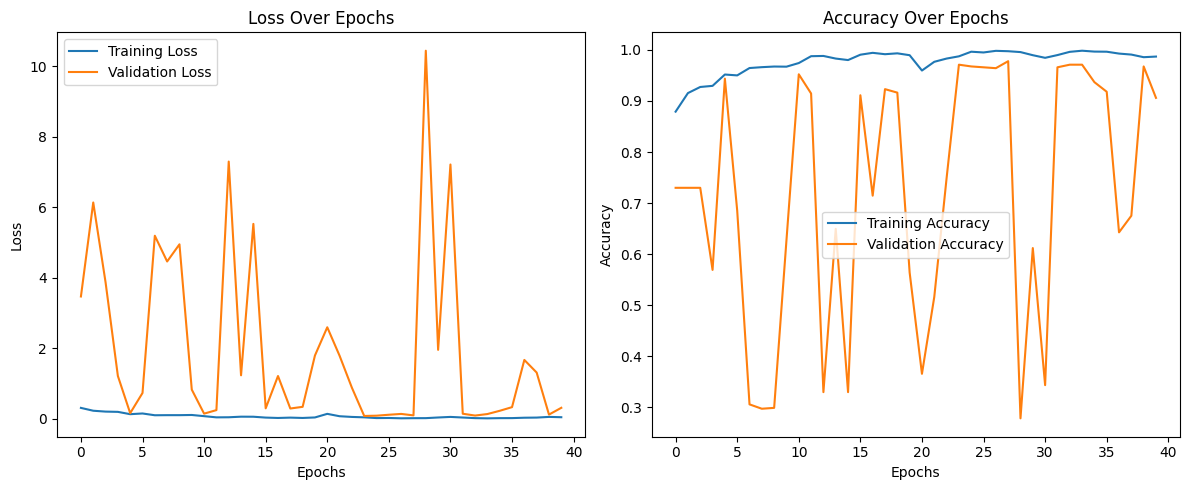

37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step

Performance on Test Data [Using Res_Net-ReLu]
Precision: 0.8936756338167526
Recall: 0.8822525597269625
F1 Score: 0.8852821484110326
Accuracy: 0.8822525597269625
Confusion Matrix:
            NORMAL  PNEUMONIA
NORMAL        279         38
PNEUMONIA     100        755


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add,
    GlobalAveragePooling2D, Flatten, Dense
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# Directory for the dataset
data_dir = dataset

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'Validate'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'Test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Training the model
history = model.fit(train_generator, epochs=40, validation_data=val_generator)

# Plot training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Helper function to evaluate the model on given test generator
def evaluate_model(test_generator, model, classes, title="Performance"):
    y_test_pred = model.predict(test_generator)
    y_test_pred = np.argmax(y_test_pred, axis=1)

    precision = precision_score(test_generator.labels, y_test_pred, average='weighted')
    recall = recall_score(test_generator.labels, y_test_pred, average='weighted')
    f1 = f1_score(test_generator.labels, y_test_pred, average='weighted')
    accuracy = accuracy_score(test_generator.labels, y_test_pred)

    print(f"\n{title}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)

    # Display the confusion matrix
    confusion = confusion_matrix(test_generator.labels, y_test_pred)
    confusion_df = pd.DataFrame(confusion, index=classes, columns=classes)
    print("Confusion Matrix:\n", confusion_df)

# Test the model on the test set
evaluate_model(test_generator, model, ['NORMAL','PNEUMONIA'], title="Performance on Test Data [Using Res_Net-ReLu]")


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, AveragePooling2D, Flatten, Dense

def conv_block(inputs, filters, kernel_size, strides=(1, 1)):
    x = Conv2D(filters=filters[0], kernel_size=(1, 1), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv2D(filters=filters[2], kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters=filters[2], kernel_size=(1, 1), strides=strides, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('swish')(x)
    return x

def identity_block(inputs, filters):
    x = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv2D(filters=filters[2], kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, inputs])
    x = Activation('swish')(x)
    return x

def resnet_50():
    inputs = Input(shape=(224, 224, 3))

    # Initial layers
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = conv_block(x, [64, 64, 256], (3, 3))
    for _ in range(2):
        x = identity_block(x, [64, 64, 256])

    x = conv_block(x, [128, 128, 512], (3, 3), strides=(2, 2))
    for _ in range(3):
        x = identity_block(x, [128, 128, 512])

    x = conv_block(x, [256, 256, 1024], (3, 3), strides=(2, 2))
    for _ in range(5):
        x = identity_block(x, [256, 256, 1024])

    x = conv_block(x, [512, 512, 2048], (3, 3), strides=(2, 2))
    for _ in range(2):
        x = identity_block(x, [512, 512, 2048])

    # Final layers
    x = AveragePooling2D((7, 7))(x)
    x = Flatten()(x)
    classes=2
    outputs = Dense(classes, activation='softmax')(x)

    resnet50 = Model(inputs=inputs, outputs=outputs)
    resnet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return resnet50

model = resnet_50()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_106 (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_106   │ (None, 112, 112, 64)   │            256 │ conv2d_106[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_98             │ (None, 112, 112, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 56, 56, 64)     │              0 │ activation_98[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_107 (Conv2D)       │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_107   │ (None, 56, 56, 64)     │            256 │ conv2d_107[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_99             │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_108 (Conv2D)       │ (None, 56, 56, 64)     │         36,928 │ activation_99[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_108   │ (None, 56, 56, 64)     │            256 │ conv2d_108[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_100            │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_109 (Conv2D)       │ (None, 56, 56, 256)    │         16,640 │ activation_100[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_110 (Conv2D)       │ (None, 56, 56, 256)    │         16,640 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_109   │ (None, 56, 56, 256)    │          1,024 │ conv2d_109[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_110   │ (None, 56, 56, 256)    │          1,024 │ conv2d_110[0][0]       │
│ (BatchNormalization) 

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

Found 4099 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 116s 497ms/step - accuracy: 0.8039 - loss: 0.5018 - val_accuracy: 0.7299 - val_loss: 0.6094
Epoch 2/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 293ms/step - accuracy: 0.9103 - loss: 0.2344 - val_accuracy: 0.7299 - val_loss: 1.6549
Epoch 3/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 297ms/step - accuracy: 0.9126 - loss: 0.2144 - val_accuracy: 0.7299 - val_loss: 2.8982
Epoch 4/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 301ms/step - accuracy: 0.9442 - loss: 0.1355 - val_accuracy: 0.7299 - val_loss: 2.4077
Epoch 5/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - accuracy: 0.9597 - loss: 0.1125 - val_accuracy: 0.5932 - val_loss: 0.8409
Epoch 6/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 306ms/step - accuracy: 0.9668 - loss: 0.0871 - val_accuracy: 0.8855 - val_loss: 0.2558
Epoch 7/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 309ms/step - accuracy: 0.9786 - loss: 0.0612 - val_accuracy: 0.4239 - val_loss: 1.6230
Epoch 8/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 310ms/step - accuracy: 0.9695 - loss: 0.0833 - va

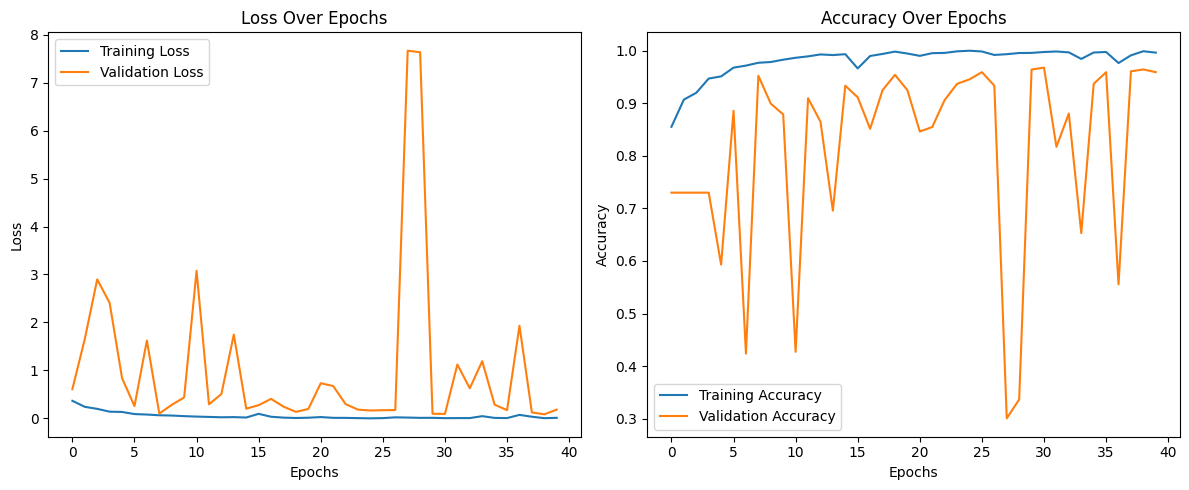

37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step

Performance on Test Data [Using Res_Net-Swish]
Precision: 0.9281079863896305
Recall: 0.9283276450511946
F1 Score: 0.9266442999874904
Accuracy: 0.9283276450511946
Confusion Matrix:
            NORMAL  PNEUMONIA
NORMAL        254         63
PNEUMONIA      21        834


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add,
    GlobalAveragePooling2D, Flatten, Dense
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# Directory for the dataset
data_dir = dataset

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'Validate'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'Test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Training the model
history = model.fit(train_generator, epochs=40, validation_data=val_generator)

# Plot training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Helper function to evaluate the model on given test generator
def evaluate_model(test_generator, model, classes, title="Performance"):
    y_test_pred = model.predict(test_generator)
    y_test_pred = np.argmax(y_test_pred, axis=1)

    precision = precision_score(test_generator.labels, y_test_pred, average='weighted')
    recall = recall_score(test_generator.labels, y_test_pred, average='weighted')
    f1 = f1_score(test_generator.labels, y_test_pred, average='weighted')
    accuracy = accuracy_score(test_generator.labels, y_test_pred)

    print(f"\n{title}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)

    # Display the confusion matrix
    confusion = confusion_matrix(test_generator.labels, y_test_pred)
    confusion_df = pd.DataFrame(confusion, index=classes, columns=classes)
    print("Confusion Matrix:\n", confusion_df)

# Test the model on the test set
evaluate_model(test_generator, model, ['NORMAL','PNEUMONIA'], title="Performance on Test Data [Using Res_Net-Swish]")